<a href="https://colab.research.google.com/github/gyrao72/Face-Mask-Detection/blob/main/FaceMask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [3]:
DIRECTORY = "drive/MyDrive/FaceMaskdata/dataset"
CATEGORIES = ["with_mask", "without_mask"]

In [4]:
data = []
labels = []

In [5]:
for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
    	img_path = os.path.join(path, img)
    	image = load_img(img_path, target_size=(224, 224))
    	image = img_to_array(image)
    	image = preprocess_input(image)

    	data.append(image)
    	labels.append(category)

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [6]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [7]:
data = np.array(data, dtype="float32")
labels = np.array(labels)

In [8]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,test_size=0.20, stratify=labels, random_state=42)

In [9]:
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	  rotation_range=20,
	  zoom_range=0.15,
	  width_shift_range=0.2,
	  height_shift_range=0.2,
	  shear_range=0.15,
	  horizontal_flip=True,
	  fill_mode="nearest"
  )

In [10]:
# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))

9420800/9406464 [==============================] - 0s 0us/step


In [11]:
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [12]:
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

In [13]:
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
  layer.trainable = False

In [15]:
# compile our model
print("[INFO] compiling model...")
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

[INFO] compiling model...


In [16]:
# train the head of the network
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

[INFO] training head...
Epoch 1/20
96/96 [==============================] - 73s 430ms/step - loss: 0.4023 - accuracy: 0.8540 - val_loss: 0.1647 - val_accuracy: 0.9766
Epoch 2/20
96/96 [==============================] - 38s 396ms/step - loss: 0.1541 - accuracy: 0.9668 - val_loss: 0.0873 - val_accuracy: 0.9818
Epoch 3/20
96/96 [==============================] - 38s 392ms/step - loss: 0.1001 - accuracy: 0.9744 - val_loss: 0.0628 - val_accuracy: 0.9870
Epoch 4/20
96/96 [==============================] - 37s 389ms/step - loss: 0.0835 - accuracy: 0.9790 - val_loss: 0.0506 - val_accuracy: 0.9883
Epoch 5/20
96/96 [==============================] - 37s 382ms/step - loss: 0.0693 - accuracy: 0.9806 - val_loss: 0.0438 - val_accuracy: 0.9896
Epoch 6/20
96/96 [==============================] - 37s 385ms/step - loss: 0.0594 - accuracy: 0.9842 - val_loss: 0.0394 - val_accuracy: 0.9896
Epoch 7/20
96/96 [==============================] - 36s 379ms/step - loss: 0.0536 - accuracy: 0.9855 - val_loss: 0.036

In [17]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

[INFO] evaluating network...


In [18]:
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

In [19]:
# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       0.99      1.00      0.99       385
without_mask       1.00      0.99      0.99       384

    accuracy                           0.99       769
   macro avg       0.99      0.99      0.99       769
weighted avg       0.99      0.99      0.99       769



In [22]:
import datetime

In [23]:
#Saving the model
def save_model(model,suffix=None):
  modeldir=os.path.join("drive/MyDrive/FaceMaskdata/models",
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))
  model_path=modeldir+"-"+suffix+".h5"
  print(f"saving model to: {model_path}.....")
  model.save(model_path)
  return model_path

In [24]:
save_model(model,suffix="first")

saving model to: drive/MyDrive/FaceMaskdata/models/20211028-14561635433004-first.h5.....


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


'drive/MyDrive/FaceMaskdata/models/20211028-14561635433004-first.h5'

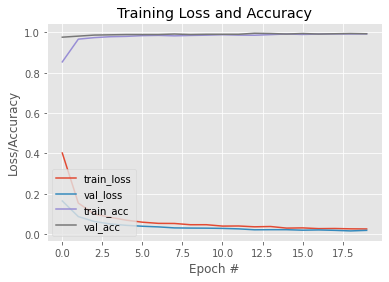

In [25]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")